In [1]:
!pip install XGBoost

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install seaborn==0.9.0

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [4]:
df = pd.read_csv('s3://partly-cloudy-ml-inputs/SEATTLE_every_6_hour_flat.csv')
df.head()

,localDateTime,Nx,Ny,Lat,Lon,geoEncode,NAME,iSSRs200430,iSSRs300430,meanTemp200430,meanTemp300430,meanRH_ice200430,meanRH_ice300430
0,2020-05-31 18:00:00,32,137,41.492776,-126.319147,9pqhj,SEATTLE,0,0,233.943167,223.304333,57.157500,44.665000
1,2020-08-13 06:00:00,32,137,41.492776,-126.319147,9pqhj,SEATTLE,0,0,238.225333,224.533667,38.836667,41.683333
2,2020-10-23 06:00:00,32,137,41.492776,-126.319147,9pqhj,SEATTLE,0,0,234.143500,221.185333,31.104167,44.295000
3,2021-01-09 12:00:00,32,137,41.492776,-126.319147,9pqhj,SEATTLE,0,0,229.740167,216.532333,68.199167,57.123333
4,2021-03-23 00:00:00,32,137,41.492776,-126.319147,9pqhj,SEATTLE,0,0,229.031583,216.086667,46.365000,62.908333


In [5]:
#Creating a subset of the dataframe - Going to just look at ISSRs at FL 300 to FL 370
df = df[['localDateTime', 'iSSRs300430','Nx', 'Ny', 'meanTemp300430', 'meanRH_ice300430']]
df = df.rename(columns={'iSSRs300430': 'ISSRCount'})
df.head()

,localDateTime,ISSRCount,Nx,Ny,meanTemp300430,meanRH_ice300430
0,2020-05-31 18:00:00,0,32,137,223.304333,44.665000
1,2020-08-13 06:00:00,0,32,137,224.533667,41.683333
2,2020-10-23 06:00:00,0,32,137,221.185333,44.295000
3,2021-01-09 12:00:00,0,32,137,216.532333,57.123333
4,2021-03-23 00:00:00,0,32,137,216.086667,62.908333


In [6]:
#Convert variables into appropriate formats for analysis
#1. localDateTime -> Date object
df['localDateTime'] = pd.to_datetime(df['localDateTime'], infer_datetime_format=True)
#Check change has occured
#df.info()

In [7]:
#df.sort_values('localDateTime')

In [8]:
#test date is randomly picked - 2020/12/20
df = df[df.localDateTime <= '2020-12-06 00:00:00']
df = df[df.localDateTime >= '2020-11-05 00:00:00']
df

,localDateTime,ISSRCount,Nx,Ny,meanTemp300430,meanRH_ice300430
8,2020-12-04 12:00:00,0,32,137,220.955333,39.275000
17,2020-11-19 18:00:00,0,32,137,221.200000,16.965000
33,2020-11-09 12:00:00,0,32,137,223.306167,48.908333
56,2020-11-05 00:00:00,0,32,137,223.324333,50.733333
63,2020-12-03 06:00:00,0,32,137,223.236333,17.570000
...,...,...,...,...,...,...
2720148,2020-12-02 06:00:00,0,50,163,220.380333,26.021667
2720164,2020-12-05 00:00:00,0,50,163,220.230833,69.331667
2720182,2020-11-21 12:00:00,0,50,163,213.983167,62.885000
2720183,2020-11-27 06:00:00,0,50,163,216.756833,76.588333


In [9]:
features = ['Nx', 'Ny', 'meanTemp300430', 'meanRH_ice300430']
label = 'ISSRCount'
test_df = df[df.localDateTime >= '2020-12-05 00:00:00']
train_df = df[df.localDateTime < '2020-12-05 00:00:00']
X_train, y_train = train_df[features], train_df[label]
X_test, y_test = test_df[features], test_df[label]

In [10]:
params = { 'max_depth': [3, 6, 10, 15],
           'learning_rate': [0.01, 0.2],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0),
           'colsample_bylevel': np.arange(0.4, 1.0),
           'n_estimators': [100, 500]}

In [11]:
xgbr = xgb.XGBRegressor(seed = 20)

In [12]:
clf = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         n_iter=25,
                         verbose=1)

In [13]:
reg = clf.fit(X_train, 
              y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              eval_metric='mae')

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[0]	validation_0-mae:0.52318	validation_1-mae:0.53416
[1]	validation_0-mae:0.51946	validation_1-mae:0.53000
[2]	validation_0-mae:0.51533	validation_1-mae:0.52564
[3]	validation_0-mae:0.51182	validation_1-mae:0.52197
[4]	validation_0-mae:0.50834	validation_1-mae:0.51833
[5]	validation_0-mae:0.50431	validation_1-mae:0.51410
[6]	validation_0-mae:0.50091	validation_1-mae:0.51055
[7]	validation_0-mae:0.49741	validation_1-mae:0.50662
[8]	validation_0-mae:0.49394	validation_1-mae:0.50273
[9]	validation_0-mae:0.49063	validation_1-mae:0.49927
[10]	validation_0-mae:0.48734	validation_1-mae:0.49584
[11]	validation_0-mae:0.48411	validation_1-mae:0.49247
[12]	validation_0-mae:0.48090	validation_1-mae:0.48912
[13]	validation_0-mae:0.47759	validation_1-mae:0.48539
[14]	validation_0-mae:0.47445	validation_1-mae:0.48212
[15]	validation_0-mae:0.47076	validation_1-mae:0.47824
[16]	validation_0-mae:0.46711	validation_1-mae:0.47440
[17]	validati

In [14]:
print("Best parameters:", clf.best_params_)

Best parameters: {'subsample': 0.5, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.4}


In [15]:
#print("Lowest RMSE:", (clf.best_score)**(1/2.0))

In [16]:
#reg = XGBRegressor(n_estimators=500, learning_rate=0.01)
#reg.fit(X_train,
#        y_train,
#        eval_set=[(X_train, y_train), (X_test, y_test)],
#        eval_metric='mae')

In [17]:
y_pred = reg.predict(X_test)

In [18]:
test_df = test_df.reset_index().drop('index', axis=1)
test_df['y_pred'] = pd.Series(y_pred)

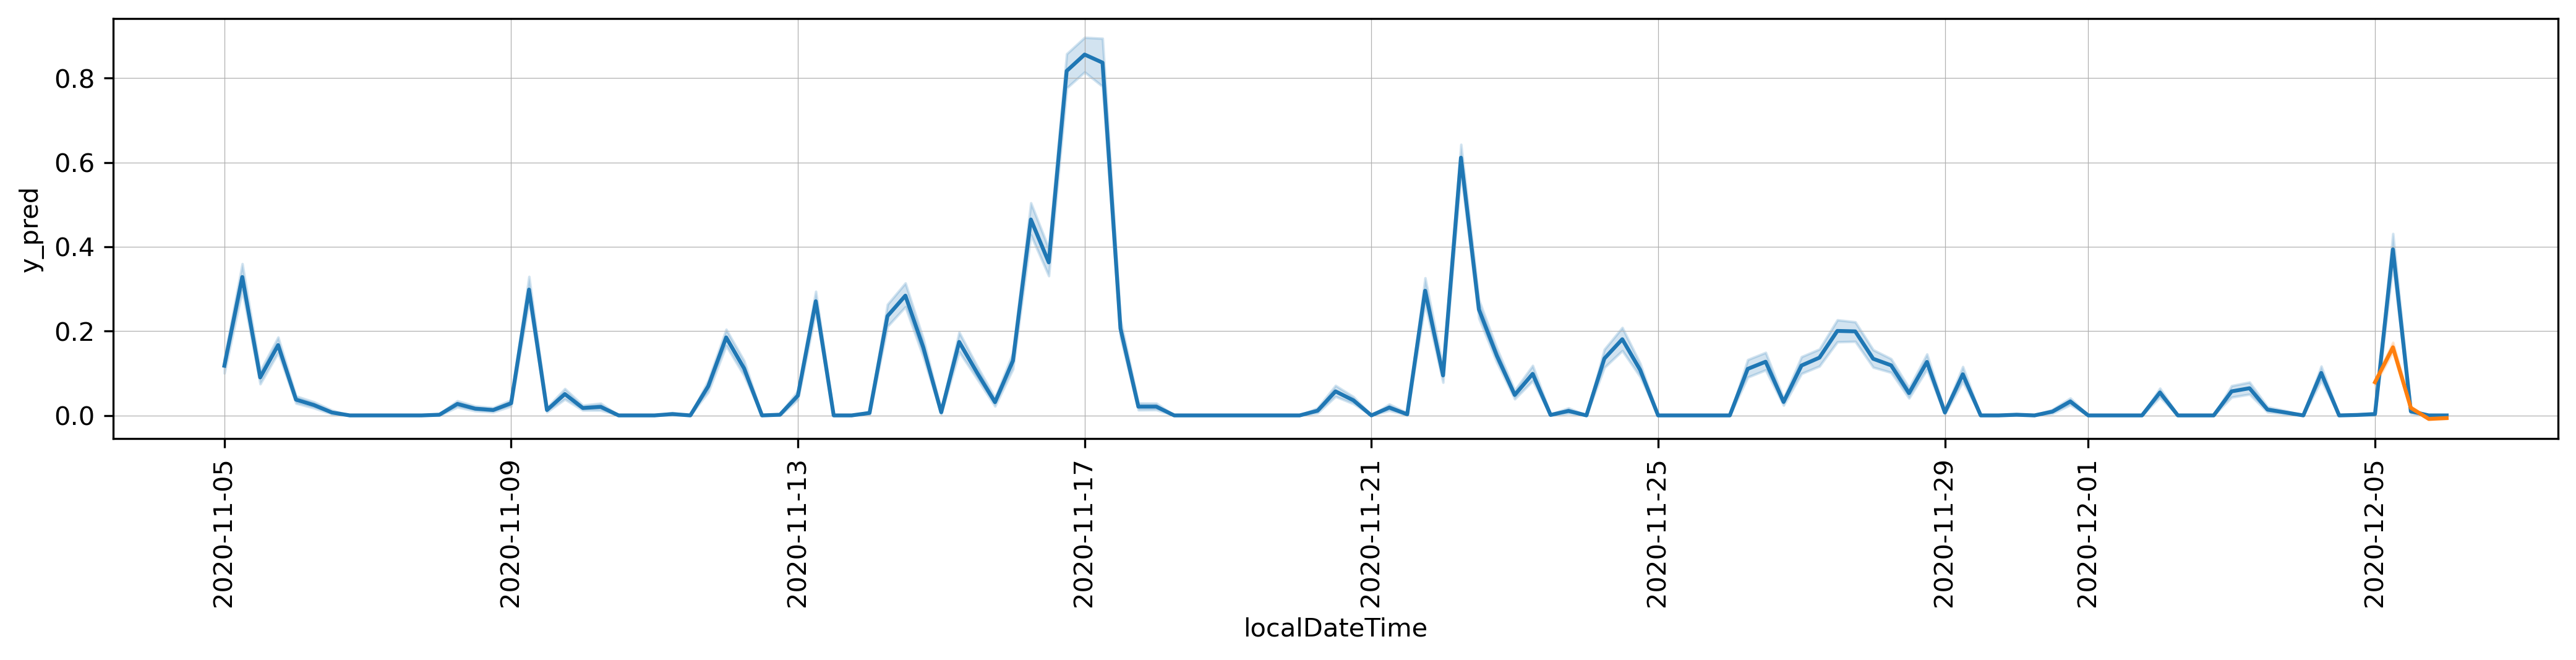

In [19]:
plt.rcParams.update({'figure.figsize': (17,3), 'figure.dpi': 300})
fit, ax = plt.subplots()
sns.lineplot(data=df, x='localDateTime',y='ISSRCount')
sns.lineplot(data=test_df, x='localDateTime',y='y_pred')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [20]:
test_df

,localDateTime,ISSRCount,Nx,Ny,meanTemp300430,meanRH_ice300430,y_pred
0,2020-12-06 00:00:00,0,32,137,222.335833,28.408333,0.010526
1,2020-12-05 06:00:00,1,32,137,223.106833,68.728333,0.150119
2,2020-12-05 00:00:00,0,32,137,222.439000,59.406667,0.089617
3,2020-12-05 18:00:00,0,32,137,225.170333,14.770000,-0.004504
4,2020-12-05 12:00:00,0,32,137,225.978667,15.446667,-0.011853
...,...,...,...,...,...,...,...
9375,2020-12-05 06:00:00,0,50,163,220.679833,69.050000,0.239876
9376,2020-12-05 12:00:00,0,50,163,222.780667,37.285000,0.024733
9377,2020-12-06 00:00:00,0,50,163,228.033667,8.541667,0.030065
9378,2020-12-05 18:00:00,0,50,163,225.566167,21.493333,0.002025


In [21]:
test_df['y_pred'] = round(test_df['y_pred'],0)
test_df

,localDateTime,ISSRCount,Nx,Ny,meanTemp300430,meanRH_ice300430,y_pred
0,2020-12-06 00:00:00,0,32,137,222.335833,28.408333,0.0
1,2020-12-05 06:00:00,1,32,137,223.106833,68.728333,0.0
2,2020-12-05 00:00:00,0,32,137,222.439000,59.406667,0.0
3,2020-12-05 18:00:00,0,32,137,225.170333,14.770000,-0.0
4,2020-12-05 12:00:00,0,32,137,225.978667,15.446667,-0.0
...,...,...,...,...,...,...,...
9375,2020-12-05 06:00:00,0,50,163,220.679833,69.050000,0.0
9376,2020-12-05 12:00:00,0,50,163,222.780667,37.285000,0.0
9377,2020-12-06 00:00:00,0,50,163,228.033667,8.541667,0.0
9378,2020-12-05 18:00:00,0,50,163,225.566167,21.493333,0.0


In [22]:
test_df['y_pred'].describe()

count    9380.000000
mean        0.029744
std         0.172382
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: y_pred, dtype: float64

In [23]:
test_df['ISSRCount'].describe()

count    9380.000000
mean        0.081343
std         0.406910
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         3.000000
Name: ISSRCount, dtype: float64

In [24]:
test_df['localDateTime'] = pd.to_datetime(test_df['localDateTime']) 

#Create a new dataframe of just the datetime, original ISSR counts, and predicted ISSR counts
df_ISSR_counts = test_df[['localDateTime', 'ISSRCount', 'y_pred']].copy()
print(df_ISSR_counts)

#group the dataframe by date and sum of the ISSR counts
df_ISSR_counts.resample('D', on='localDateTime').sum()

           localDateTime  ISSRCount  y_pred
0    2020-12-06 00:00:00          0     0.0
1    2020-12-05 06:00:00          1     0.0
2    2020-12-05 00:00:00          0     0.0
3    2020-12-05 18:00:00          0    -0.0
4    2020-12-05 12:00:00          0    -0.0
...                  ...        ...     ...
9375 2020-12-05 06:00:00          0     0.0
9376 2020-12-05 12:00:00          0     0.0
9377 2020-12-06 00:00:00          0     0.0
9378 2020-12-05 18:00:00          0     0.0
9379 2020-12-05 00:00:00          0     0.0

[9380 rows x 3 columns]


,ISSRCount,y_pred
localDateTime,,
2020-12-05,763,279.0
2020-12-06,0,0.0


In [25]:
#Examines sum of ISSRs in 6 hour time intervals
df_sum = df_ISSR_counts.resample('6H', on='localDateTime').sum()
df_sum

,ISSRCount,y_pred
localDateTime,,
2020-12-05 00:00:00,6,8.0
2020-12-05 06:00:00,739,271.0
2020-12-05 12:00:00,18,0.0
2020-12-05 18:00:00,0,0.0
2020-12-06 00:00:00,0,0.0


In [26]:
# convert the index to column
df_sum.reset_index(inplace=True)
df_sum

,localDateTime,ISSRCount,y_pred
0,2020-12-05 00:00:00,6,8.0
1,2020-12-05 06:00:00,739,271.0
2,2020-12-05 12:00:00,18,0.0
3,2020-12-05 18:00:00,0,0.0
4,2020-12-06 00:00:00,0,0.0


In [27]:
train_df['localDateTime'] = pd.to_datetime(train_df['localDateTime']) 

#Create a new dataframe of just the datetime, original ISSR counts, and predicted ISSR counts
df_ISSR_counts_train = train_df[['localDateTime', 'ISSRCount']].copy()
print(df_ISSR_counts_train)

#group the dataframe by date and sum of the ISSR counts
df_ISSR_counts_train.resample('D', on='localDateTime').sum()
df_sum_train = df_ISSR_counts_train.resample('6H', on='localDateTime').sum()

              localDateTime  ISSRCount
8       2020-12-04 12:00:00          0
17      2020-11-19 18:00:00          0
33      2020-11-09 12:00:00          0
56      2020-11-05 00:00:00          0
63      2020-12-03 06:00:00          0
...                     ...        ...
2720130 2020-11-21 06:00:00          0
2720148 2020-12-02 06:00:00          0
2720182 2020-11-21 12:00:00          0
2720183 2020-11-27 06:00:00          0
2720186 2020-11-29 06:00:00          0

[225120 rows x 2 columns]


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [28]:
# convert the index to column
df_sum_train.reset_index(inplace=True)
df_sum_train

,localDateTime,ISSRCount
0,2020-11-05 00:00:00,221
1,2020-11-05 06:00:00,616
2,2020-11-05 12:00:00,169
3,2020-11-05 18:00:00,313
4,2020-11-06 00:00:00,70
...,...,...
115,2020-12-03 18:00:00,13
116,2020-12-04 00:00:00,0
117,2020-12-04 06:00:00,189
118,2020-12-04 12:00:00,0


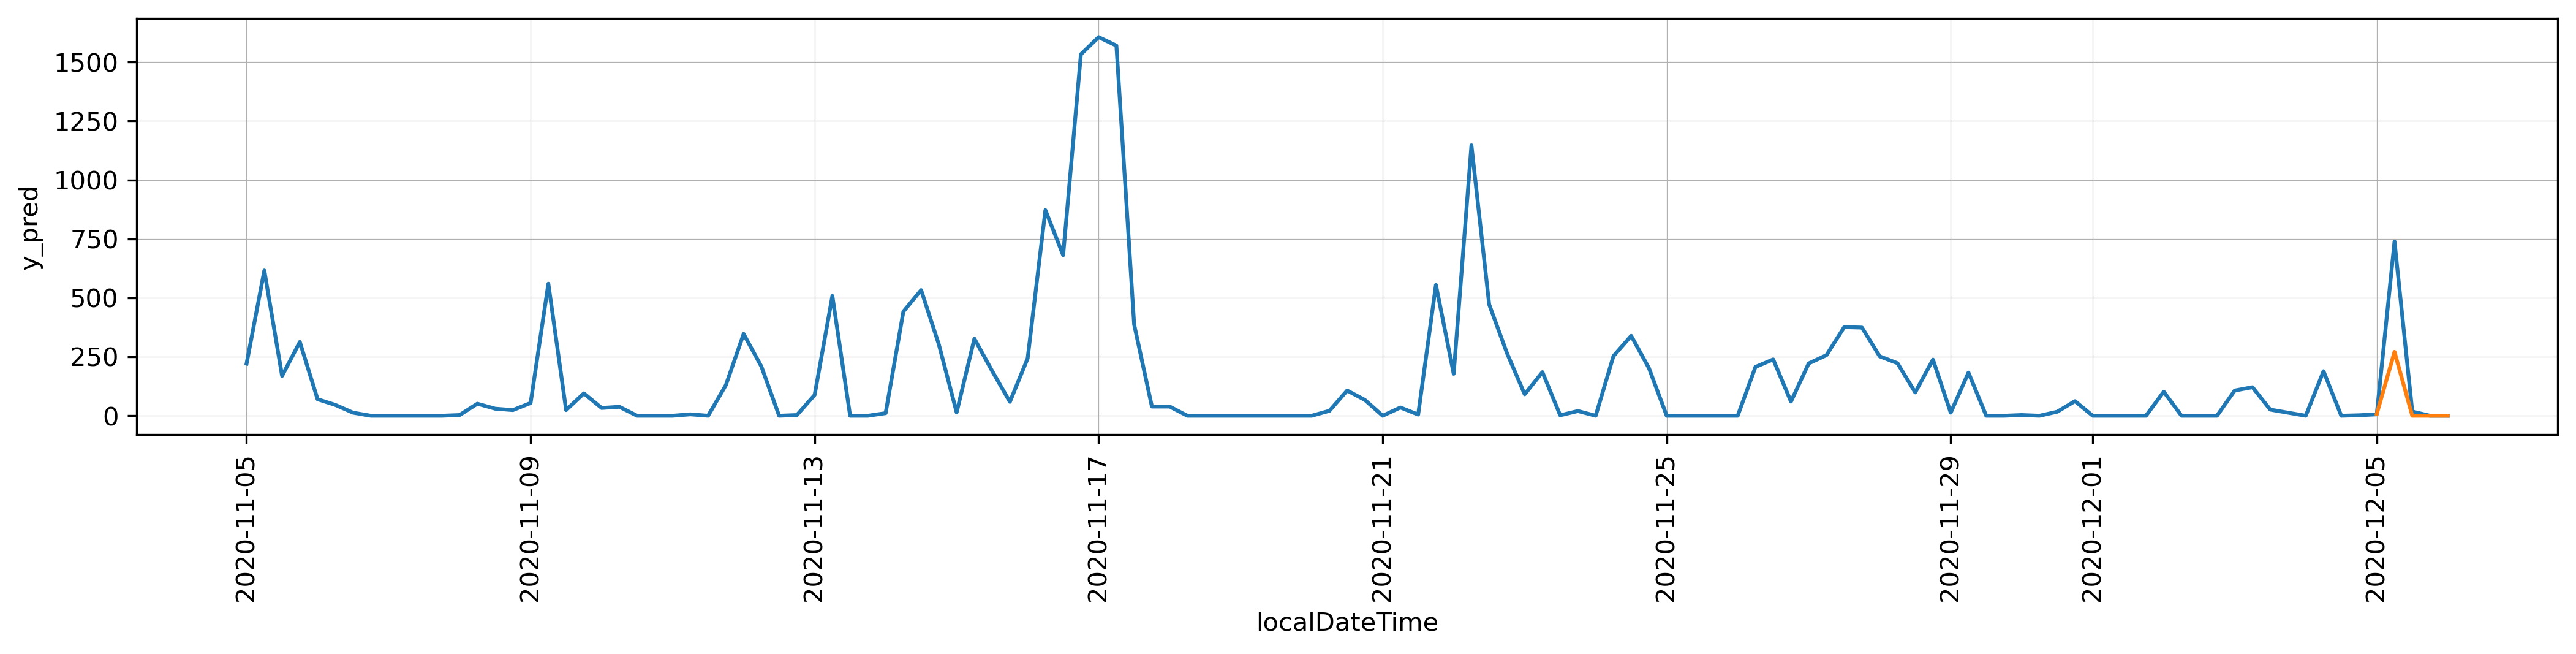

In [29]:
plt.rcParams.update({'figure.figsize': (17,3), 'figure.dpi': 300})
fit, ax = plt.subplots()
sns.lineplot(data=pd.concat([df_sum_train, df_sum]), x='localDateTime',y='ISSRCount')
sns.lineplot(data=df_sum, x='localDateTime',y='y_pred')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [30]:
confusion_matrix = pd.crosstab(test_df['ISSRCount'], test_df['y_pred'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,0.0,1.0,2.0
Actual,,,
0,8919,54,0
1,90,31,0
2,96,118,2
3,0,68,2


In [31]:
#from sklearn.metrics import plot_confusion_matrix
#disp = plot_confusion_matrix(reg, X_test, y_test,
#                           display_labels = label,
#                           cmap = plt.cm.Blues)
#plt.show()

In [32]:
# For predicted value 0:
TP=8919
TN=223   #=31+118+2+68+2
FP=186  #=90+96
FN=54   #=54

In [33]:
# true positive rate
TP_rate = TP/(TP+FN)
print("True positive: %.2f%%" % (TP_rate* 100.0))
#Specificity or true negative rate
#TN_rate = TN/(TN+FP) 
#print("True negative: %.2f%%" % (TN_rate* 100.0))
# Precision or positive predictive value
Precision_rate = TP/(TP+FP)
print("Precision: %.2f%%" % (Precision_rate* 100.0))
# Negative predictive value
#NP_rate = TN/(TN+FN)
#print("Negative predictive: %.2f%%" % (NP_rate * 100.0))
# Fall out or false positive rate
FP_rate = FP/(FP+TN)
print("False Positive: %.2f%%" % (FP_rate * 100.0))
# False negative rate
FN_rate = FN/(TP+FN)
print("False Negative: %.2f%%" % (FN_rate * 100.0))
# False discovery rate
#FDR = FP/(TP+FP)
# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Overall accuracy for count zero: %.2f%%" % (ACC * 100.0))

True positive: 99.40%
Precision: 97.96%
False Positive: 45.48%
False Negative: 0.60%
Overall accuracy for count zero: 97.44%


In [34]:
from sklearn.metrics import accuracy_score

In [35]:
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 95.44%


In [36]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, predictions)
print('MAE: ', mae)

MAE:  0.06311300639658848


In [37]:
#output bucket - S3 bucket designation
output_bucket = 'partly-cloudy-common-area'
outputFileName = 'XGBoost_Seattle_1month.csv'
#use wrangler to write the dataframe into a csv
import awswrangler as wr
wr.s3.to_csv(test_df, f"s3://{output_bucket}/{outputFileName}", index=False)

{'paths': ['s3://partly-cloudy-common-area/XGBoost_Seattle_1month.csv'],
 'partitions_values': {}}